# Esperimenti Online Learning - Progetto di Gruppo

Questo notebook contiene tutti gli esperimenti per il progetto di Online Learning, organizzati in modo modulare e scalabile.

## Importazioni e Setup

In [15]:
# Enable automatic reloading of modules
%load_ext autoreload
%autoreload 2

print("Autoreload abilitato - i moduli verranno ricaricati automaticamente quando modificati")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Autoreload abilitato - i moduli verranno ricaricati automaticamente quando modificati


In [16]:
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Importa i moduli customizzati
from environments import *
from agents import *
from data_generators import *
from utils import *

# Configurazione grafici
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['font.size'] = 12

print("Setup completato con successo!")


Setup completato con successo!


# Task 1.1: UCB1 per Pricing Semplice

Implementazione di UCB1 per il problema di pricing con valutazioni uniformi.

Task 1.1 - UCB1 Pricing Semplice
Prezzi: [0.1 0.2 0.3 0.5 0.7 0.8]
Ricavi attesi: [0.09 0.16 0.21 0.25 0.21 0.16]
Miglior prezzo chiarveggente: 0.5 (idx 3)


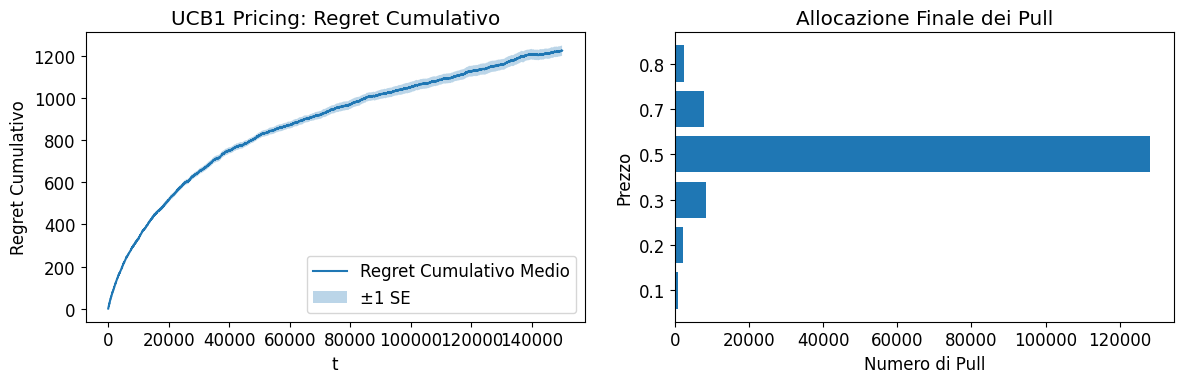


Risultati Finali Task 1.1:
Regret medio per round: 0.0082
Ricavi empirici medi: [0.09   0.1557 0.2093 0.249  0.208  0.1656]
Conteggi pull: [   800.   2088.   8384. 128192.   8000.   2536.]
Ricavi attesi reali: [0.09 0.16 0.21 0.25 0.21 0.16]


In [19]:
# Parametri per Task 1.1
prices = create_simple_prices()
T = 150_000
seed = 18
n_trials = 20

print("Task 1.1 - UCB1 Pricing Semplice")
print(f"Prezzi: {prices}")

# Clairvoyant solution
expected_revenues = prices * (1 - prices)
best_idx = np.argmax(expected_revenues)
best_price = prices[best_idx]

print(f"Ricavi attesi: {np.round(expected_revenues, 6)}")
print(f"Miglior prezzo chiarveggente: {best_price} (idx {best_idx})")

# Simulazione
np.random.seed(seed)
all_regrets = []

for trial in range(n_trials):
    rng = np.random.RandomState(seed + trial)
    env = PricingEnvironment(prices, T, rng=rng)
    agent = UCB1PricingAgent(len(prices), T)

    regrets = []
    cum_regret = 0.0
    
    for t in range(T):
        arm = agent.pull_arm()
        r = env.round(arm)
        agent.update(r)

        instant_regret = expected_revenues[best_idx] - r
        cum_regret += instant_regret
        regrets.append(cum_regret)

    all_regrets.append(regrets)

# Calcolo medie e plotting
all_regrets = np.array(all_regrets)
avg_regret = all_regrets.mean(axis=0)
sd_regret = all_regrets.std(axis=0)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(avg_regret, label="Regret Cumulativo Medio")
plt.fill_between(
    np.arange(T),
    avg_regret - sd_regret / np.sqrt(n_trials),
    avg_regret + sd_regret / np.sqrt(n_trials),
    alpha=0.3,
    label="±1 SE"
)
plt.xlabel("t")
plt.ylabel("Regret Cumulativo")
plt.title("UCB1 Pricing: Regret Cumulativo")
plt.legend()

plt.subplot(1, 2, 2)
labels = [f"{p:.1f}" for p in prices]
plt.barh(labels, agent.N_pulls)
plt.xlabel("Numero di Pull")
plt.ylabel("Prezzo")
plt.title("Allocazione Finale dei Pull")

plt.tight_layout()
plt.show()

print(f"\nRisultati Finali Task 1.1:")
print(f"Regret medio per round: {avg_regret[-1]/T:.4f}")
print(f"Ricavi empirici medi: {np.round(agent.average_rewards, 4)}")
print(f"Conteggi pull: {agent.N_pulls}")
print(f"Ricavi attesi reali: {np.round(expected_revenues, 4)}")


## Task 1.2: UCB Vincolato per Pricing con Budget

Implementazione di Constrained UCB per pricing con vincoli di budget.


Task 1.2 - UCB Vincolato per Pricing con Budget
Prezzi: 16 prezzi da 0.200 a 0.980
Budget: 4000, Orizzonte: 10000
Probabilità vendita (uniforme): primi 5 = [0.8   0.744 0.689 0.633 0.578]
Ricavi attesi: primi 5 = [0.16     0.190464 0.214279 0.232311 0.243916]
Utilità chiarveggente per round: 0.2395
Trial 1: Budget esaurito al round 8605.
Trial 1: Budget esaurito al round 8605.
Trial 2: Budget esaurito al round 8430.
Trial 2: Budget esaurito al round 8430.
Trial 3: Budget esaurito al round 8424.
Trial 3: Budget esaurito al round 8424.


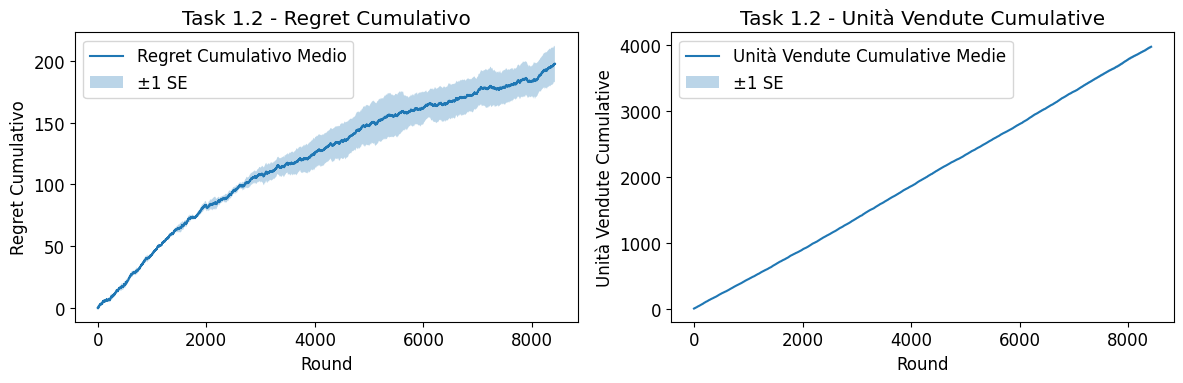


Risultati Finali:
Regret medio per round: 0.0235
Unità vendute cumulative medie: 3974.67
Ricavo cumulativo medio: 1831.79
Conteggi pull: [3.410e+02 4.130e+02 5.860e+02 6.800e+02 7.840e+02 1.066e+03 1.000e+03
 9.490e+02 7.620e+02 5.830e+02 4.530e+02 2.840e+02 2.450e+02 1.490e+02
 1.280e+02 1.000e+00]
Ricavo baseline: 2395.16


In [20]:
# Parametri per Task 1.2
prices = create_default_prices()
T = 10_000
B = 4_000
seed = 18
n_trials = 3

print("Task 1.2 - UCB Vincolato per Pricing con Budget")
print(f"Prezzi: {len(prices)} prezzi da {prices[0]:.3f} a {prices[-2]:.3f}")
print(f"Budget: {B}, Orizzonte: {T}")

# Probabilità di vendita e soluzione chiarveggente
sell_probabilities = np.maximum(0, 1-prices)
expected_reward = prices * sell_probabilities

print(f"Probabilità vendita (uniforme): primi 5 = {sell_probabilities[:5]}")
print(f"Ricavi attesi: primi 5 = {expected_reward[:5]}")

# Soluzione chiarveggente
exp_util, gamma, exp_cost = compute_clairvoyant_single_product(prices, sell_probabilities, B, T)
print(f"Utilità chiarveggente per round: {exp_util:.4f}")

# Simulazione
np.random.seed(seed)
all_regrets = []
all_units_sold = []
final_rewards = []

for trial in range(n_trials):
    rng = np.random.RandomState(seed + trial)
    env = BudgetedPricingEnvironment(prices, T, rng=rng)
    agent = ConstrainedUCBPricingAgent(len(prices), B, T, range=1)

    regrets = []
    units_sold = []
    cum_reward = 0.0
    cum_regret = 0.0
    cum_unit_sold = 0
    
    for t in range(T):
        arm = agent.pull_arm()
        if arm is None:
            print(f"Trial {trial+1}: Budget esaurito al round {t}.")
            break
            
        reward, sold = env.round(arm)
        agent.update(reward, sold)

        cum_reward += reward
        instant_regret = exp_util - reward
        
        cum_regret += instant_regret
        cum_unit_sold += sold
        regrets.append(cum_regret)
        units_sold.append(cum_unit_sold)

    all_regrets.append(regrets)
    all_units_sold.append(units_sold)
    final_rewards.append(cum_reward)

# Plotting
avg_regret, avg_units, min_rounds = plot_results(all_regrets, all_units_sold, n_trials, "Task 1.2 - ")
print_final_results(avg_regret, avg_units, min_rounds, final_rewards, agent)

baseline_reward = exp_util * T
print(f"Ricavo baseline: {baseline_reward:.2f}")


## Task 2.1: UCB Combinatoriale per Multi-Prodotto

Implementazione di Constrained Combinatorial UCB per pricing multi-prodotto con budget condiviso.


Task 2.1 - UCB Combinatoriale Multi-Prodotto
Prodotti: 3, Prezzi per prodotto: 16
Budget: 11000, Orizzonte: 10000
Expected revenue per price (f_true): [array([0.        , 0.06632653, 0.12244898, 0.16836735, 0.20408163,
       0.22959184, 0.24489796, 0.25      , 0.24489796, 0.22959184,
       0.20408163, 0.16836735, 0.12244898, 0.06632653, 0.        ,
       0.        ]), array([0.        , 0.06632653, 0.12244898, 0.16836735, 0.20408163,
       0.22959184, 0.24489796, 0.25      , 0.24489796, 0.22959184,
       0.20408163, 0.16836735, 0.12244898, 0.06632653, 0.        ,
       0.        ]), array([0.        , 0.06632653, 0.12244898, 0.16836735, 0.20408163,
       0.22959184, 0.24489796, 0.25      , 0.24489796, 0.22959184,
       0.20408163, 0.16836735, 0.12244898, 0.06632653, 0.        ,
       0.        ])]
Expected consumption per price (c_true): [array([1.        , 0.92857143, 0.85714286, 0.78571429, 0.71428571,
       0.64285714, 0.57142857, 0.5       , 0.42857143, 0.35714286,
      

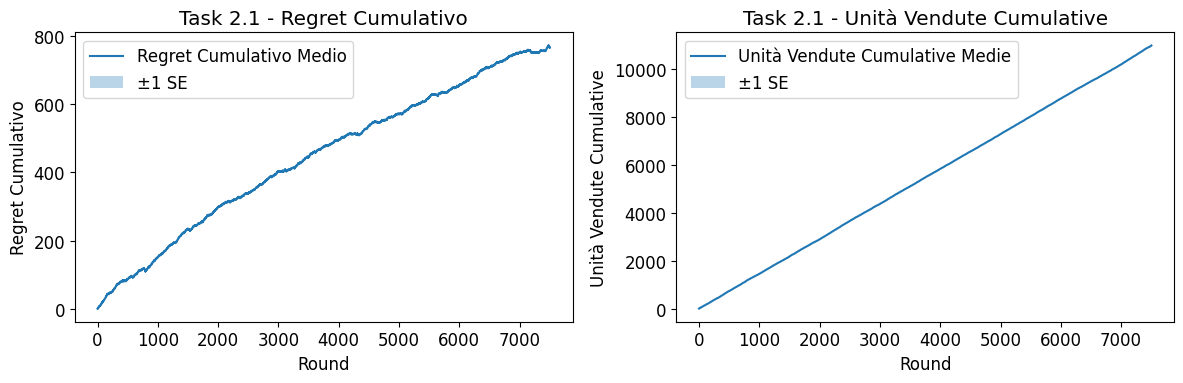


Risultati Finali Task 2.1:
Regret medio per round: 0.1020
Unità vendute cumulative medie: 11001.00
Budget utilizzato medio: 11001.0/11000 (100.0%)
Prodotto 1 - Pull counts: [121. 180. 263. 382. 571. 672. 926. 933. 986. 753. 734. 361. 219. 158.
 122. 122.]
Prodotto 2 - Pull counts: [ 124.  182.  267.  408.  554.  777.  952. 1005.  942.  701.  478.  365.
  314.  186.  124.  124.]
Prodotto 3 - Pull counts: [ 124.  183.  270.  419.  576.  700.  849. 1003.  938.  778.  521.  502.
  197.  195.  124.  124.]


In [5]:
# Parametri per Task 2.1
N_products = 3
base_prices = np.linspace(0, 1, 15)
dummy_price = 1.001
price_grid = create_multiproduct_price_grid(
    np.concatenate([base_prices, [dummy_price]]), N_products
)

T = 10_000
B = 11_000
seed = 18
n_trials = 1

print(f"Task 2.1 - UCB Combinatoriale Multi-Prodotto")
print(f"Prodotti: {N_products}, Prezzi per prodotto: {len(price_grid[0])}")
print(f"Budget: {B}, Orizzonte: {T}")

clair_reward ,simplex = solve_clairvoyant_lp(price_grid, B, T)
print(f"Clairvoyant expected reward per round: {clair_reward:.4f} and simplex: {simplex} ")


# Simulazione
all_regrets = []
all_units = []
final_rewards = []

for trial in range(n_trials):
    print(f"Trial {trial+1}/{n_trials}...")
    rng = np.random.default_rng(seed + trial)
    env = MultiProductPricingEnvironment(price_grid, T, rng=rng)
    agent = ConstrainedCombinatorialUCBAgent(price_grid, B, T , alpha=2)

    cum_regret, cum_units = 0.0, 0
    regrets, units = [], []

    for t in range(T):
        choice = agent.pull_arm()
        if choice is None:
            print(f"Trial {trial+1}: Budget esaurito al round {t}.")
            break
            
        rewards, costs = env.round(choice)
        agent.update(rewards, costs)

        actual_rew = rewards.sum()
        actual_units = costs.sum()
        cum_regret += (clair_reward - actual_rew)
        cum_units += actual_units
        regrets.append(cum_regret)
        units.append(cum_units)

    all_regrets.append(regrets)
    all_units.append(units)
    final_rewards.append(actual_rew)  # Ricavo ultimo round

# Plotting
avg_regret, avg_units, min_rounds = plot_results(all_regrets, all_units, n_trials, "Task 2.1 - ")

print(f"\nRisultati Finali Task 2.1:")
print(f"Regret medio per round: {avg_regret[-1]/min_rounds:.4f}")
print(f"Unità vendute cumulative medie: {avg_units[-1]:.2f}")
print(f"Budget utilizzato medio: {avg_units[-1]}/{B} ({100*avg_units[-1]/B:.1f}%)")

# Stampa statistiche per prodotto se disponibili
if hasattr(agent, 'N_pulls'):
    for j in range(N_products):
        print(f"Prodotto {j+1} - Pull counts: {agent.N_pulls[j]}")


## Task 3.1: Primal-Dual per Pricing Non-Stazionario

Implementazione di Full-Feedback Primal-Dual per ambienti non-stazionari con shock avversariali.


Task 3.1 - Primal-Dual per Pricing Non-Stazionario
Budget: 4000, Orizzonte: 10000
Probabilità shock: 0.5, Frequenza: 100
Prezzi: 16 da 0.200 a 0.980

Trial 1/1...
Utilità chiarveggente: 0.2544
Costo atteso per round: 0.4000
Probabilità vendita (primi 5): [0.6931 0.6704 0.6399 0.6077 0.5704]
Trial 1: Ricavo finale = 2485.99, Budget rimanente = 796


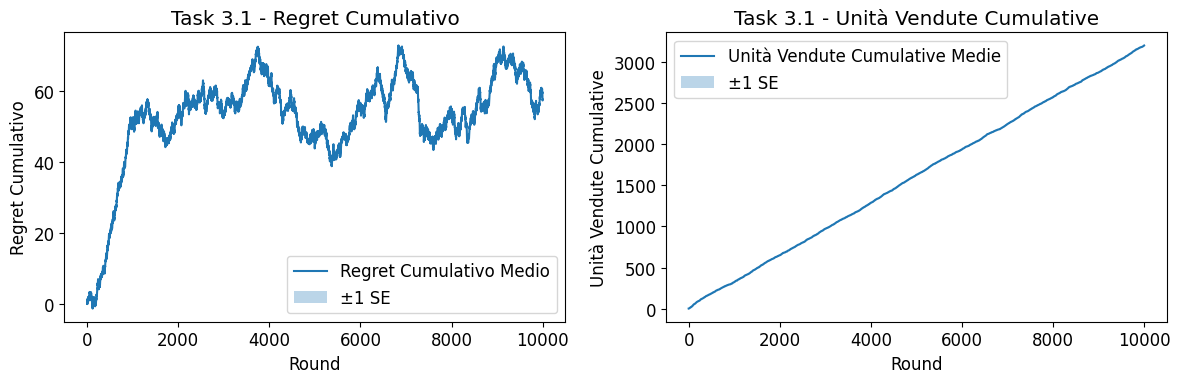


Risultati Finali Task 3.1:
Regret medio per round: 0.0058
Unità vendute cumulative medie: 3204.00
Ricavo cumulativo medio: 2485.99
Pull counts finali: [  20   20   26   40   84  182  361  541  584  747  983 1252 1188 1660
 2179  133]
Moltiplicatore λ finale: 0.0220
Ricavo baseline chiarveggente: 2543.65
Efficienza media: 97.7%


In [5]:
# Parametri per Task 3.1
prices = create_default_prices()
T = 10_000
B = 4_000
seed = 17
shock_prob = 0.50
freq = 100
n_trials = 1

print(f"Task 3.1 - Primal-Dual per Pricing Non-Stazionario")
print(f"Budget: {B}, Orizzonte: {T}")
print(f"Probabilità shock: {shock_prob}, Frequenza: {freq}")
print(f"Prezzi: {len(prices)} da {prices[0]:.3f} a {prices[-2]:.3f}")

# Simulazione
all_regrets = []
all_units_sold = []
final_rewards = []

for trial in range(n_trials):
    print(f"\nTrial {trial+1}/{n_trials}...")
    rng = np.random.RandomState(seed + trial)
    
    # Crea ambiente non-stazionario
    env = NonStationaryBudgetedPricingEnvironment(
        prices, T, shock_prob, freq, num_regimes=10000, 
        valuation_type='piecewise_beta', rng=rng
    )
    
    # Calcola soluzione chiarveggente per questo trial
    sell_probabilities = env.compute_sell_probabilities()
    exp_util, gamma, exp_cost = compute_clairvoyant_single_product(
        prices, sell_probabilities, B, T
    )
    
    if trial == 0:
        print(f"Utilità chiarveggente: {exp_util:.4f}")
        print(f"Costo atteso per round: {exp_cost:.4f}")
        print(f"Probabilità vendita (primi 5): {sell_probabilities[:5]}")
    
    # Crea agente Primal-Dual
    agent = FFPrimalDualPricingAgent(prices, T, B, rng=rng, eta=1/np.sqrt(T))

    regrets = []
    units_sold = []
    cum_reward = 0.0
    cum_regret = 0.0
    cum_unit_sold = 0
    
    for t in range(T):
        arm = agent.pull_arm()
        if arm is None:
            print(f"Trial {trial+1}: Budget esaurito al round {t}.")
            break
            
        # Full feedback: ottieni la valutazione
        valuation = env.round()
        reward, sold = agent.update(valuation)

        cum_reward += reward
        instant_regret = exp_util - reward
        
        cum_regret += instant_regret
        cum_unit_sold += sold
        regrets.append(cum_regret)
        units_sold.append(cum_unit_sold)

    all_regrets.append(regrets)
    all_units_sold.append(units_sold)
    final_rewards.append(cum_reward)
    
    print(f"Trial {trial+1}: Ricavo finale = {cum_reward:.2f}, Budget rimanente = {agent.inventory}")

# Plotting e risultati
avg_regret, avg_units, min_rounds = plot_results(all_regrets, all_units_sold, n_trials, "Task 3.1 - ")

print(f"\nRisultati Finali Task 3.1:")
print(f"Regret medio per round: {avg_regret[-1]/min_rounds:.4f}")
print(f"Unità vendute cumulative medie: {avg_units[-1]:.2f}")

if final_rewards:
    final_rewards = np.array(final_rewards)
    print(f"Ricavo cumulativo medio: {np.mean(final_rewards):.2f}")

# Statistiche sull'agente
print(f"Pull counts finali: {agent.pull_counts}")
print(f"Moltiplicatore λ finale: {agent.lmbd:.4f}")

baseline_reward = exp_util * T
print(f"Ricavo baseline chiarveggente: {baseline_reward:.2f}")
print(f"Efficienza media: {100*np.mean(final_rewards)/baseline_reward:.1f}%")


## Task 4.1: Multi-Product Primal-Dual

Implementazione di Multi-Product Full-Feedback Primal-Dual per ambienti correlati multi-prodotto.


Task 4.1 - Multi-Product Primal-Dual
Prodotti: 3, Budget: 9000, Orizzonte: 10000
Prezzi: 12 da 0.200 a 0.950
Parametri correlazione: μ₀=0.5, ρ₀=0.6

Trial 1/1...
Ricavo chiarveggente per round: 0.5223
Costo atteso per round: 0.9000
Gamma ottimale shape: (3, 12)
Media gamma per prodotto: [0.08333333 0.08333333 0.08333333]
Trial 1: Ricavo cumulativo finale = 4673.49
Trial 1: Budget rimanente = 100
Trial 1: λ finale = 1.0000


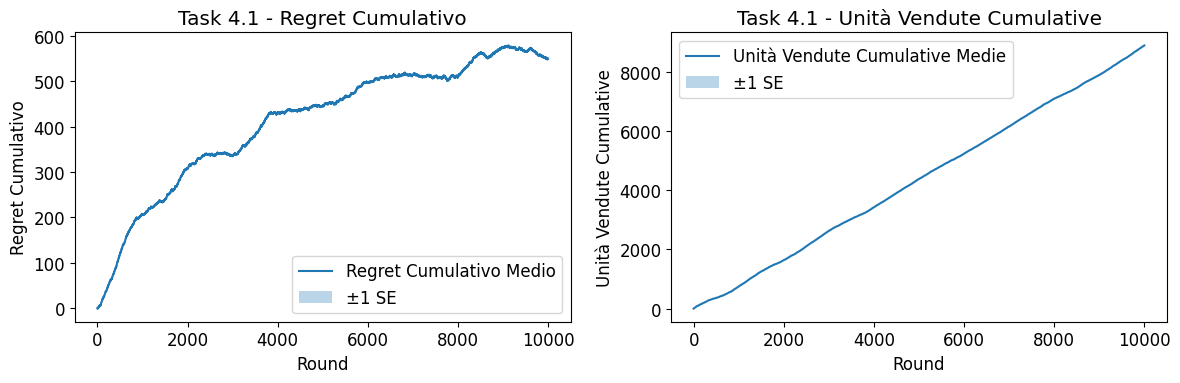


Risultati Finali Task 4.1:
Regret medio per round: 0.0550
Unità vendute cumulative medie: 8900.00
Ricavo cumulativo medio finale: 4673.49

Analisi Multi-Prodotto (ultimo trial):
Prodotto 1:
  - Prezzi scelti: 10000 volte
  - Prezzi venduti: 3064 volte
  - Prezzo medio scelto: 0.616
  - Prezzo medio venduto: 0.524
  - Tasso di conversione: 30.6%
Prodotto 2:
  - Prezzi scelti: 10000 volte
  - Prezzi venduti: 2955 volte
  - Prezzo medio scelto: 0.621
  - Prezzo medio venduto: 0.523
  - Tasso di conversione: 29.6%
Prodotto 3:
  - Prezzi scelti: 10000 volte
  - Prezzi venduti: 2881 volte
  - Prezzo medio scelto: 0.623
  - Prezzo medio venduto: 0.529
  - Tasso di conversione: 28.8%

Efficienza complessiva: 89.5%


In [8]:
# Parametri per Task 4.1
T = 10_000
m = 3  # numero di prodotti
B = 9_000
seed = 42
n_trials = 1

# Prezzi: braccio dummy > 1 per rappresentare "non vendere"
prices = np.array([0.2, 0.256, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.85, 0.9, 0.95, 1.1])

# Parametri per generazione valutazioni multivariate
mu0, A, f = 0.5, 0.1, 10
phi = np.zeros(m)
sigma0, A_sigma, phi_sigma, rho0 = 0.1, 0.1, 0, 0.6

print(f"Task 4.1 - Multi-Product Primal-Dual")
print(f"Prodotti: {m}, Budget: {B}, Orizzonte: {T}")
print(f"Prezzi: {len(prices)} da {prices[0]:.3f} a {prices[-2]:.3f}")
print(f"Parametri correlazione: μ₀={mu0}, ρ₀={rho0}")

# Simulazione
all_regrets = []
all_units_sold = []
final_rewards = []

for trial in range(n_trials):
    print(f"\nTrial {trial+1}/{n_trials}...")
    trial_rng = np.random.default_rng(seed + trial)
    
    # Genera valutazioni piecewise-stazionarie per questo trial
    V, _ = generate_piecewise_tv_mv_gauss(T, m, num_regimes=10000, rng=trial_rng)
    #V, _ = generate_simple_tv_mv_gauss(T, m, mu0, A, f, phi, sigma0, A_sigma, phi_sigma, rho0, rng=trial_rng)
    # Calcola soluzione chiarveggente
    exp_util, gamma, exp_cost = compute_extended_clairvoyant(V, prices, B)
    
    if trial == 0:
        print(f"Ricavo chiarveggente per round: {exp_util:.4f}")
        print(f"Costo atteso per round: {exp_cost:.4f}")
        print(f"Gamma ottimale shape: {gamma.shape}")
        print(f"Media gamma per prodotto: {gamma.mean(axis=1)}")
    
    # Crea ambiente con valutazioni pre-generate
    valuation_params = {
        'mu0': mu0, 'A': A, 'f': f, 'phi': phi,
        'sigma0': sigma0, 'A_sigma': A_sigma, 'phi_sigma': phi_sigma, 'rho0': rho0,
        'num_regimes': 10000
    }
    
    env = MultiProductBudgetedPricingEnvironment(
        prices, T, m, valuation_params, valuation_type='piecewise_tv', rng=trial_rng
    )
    # Sostituisci con le valutazioni calcolate
    env.V = V
    
    # Crea agente Multi-Product Primal-Dual
    eta = 1 / np.sqrt(T)
    agent = MultiProductFFPrimalDualPricingAgent(prices, T, B, m, trial_rng, eta)
    
    regrets = []
    units_sold = []
    cum_reward = 0.0
    cum_regret = 0.0
    cum_units = 0
    
    for t in range(T):
        if agent.inventory < 1:
            print(f"Trial {trial+1}: Budget esaurito al round {t}.")
            break
            
        # Full feedback: ottieni valutazioni per tutti i prodotti
        v_t = env.round()
        reward, sold = agent.update(v_t)
        
        cum_reward += reward
        instant_regret = exp_util - reward
        cum_regret += instant_regret
        cum_units += sold
        regrets.append(cum_regret)
        units_sold.append(cum_units)
    
    all_regrets.append(regrets)
    all_units_sold.append(units_sold)
    final_rewards.append(cum_reward)
    
    print(f"Trial {trial+1}: Ricavo cumulativo finale = {cum_reward:.2f}")
    print(f"Trial {trial+1}: Budget rimanente = {agent.inventory}")
    print(f"Trial {trial+1}: λ finale = {agent.lmbd:.4f}")

# Plotting e risultati
avg_regret, avg_units, min_rounds = plot_results(all_regrets, all_units_sold, n_trials, "Task 4.1 - ")

print(f"\nRisultati Finali Task 4.1:")
print(f"Regret medio per round: {avg_regret[-1]/min_rounds:.4f}")
print(f"Unità vendute cumulative medie: {avg_units[-1]:.2f}")
print(f"Ricavo cumulativo medio finale: {np.mean(final_rewards):.2f}")

# Debug: analisi per prodotto dell'ultimo agente
if hasattr(agent, 'debug_chosen_prices'):
    print(f"\nAnalisi Multi-Prodotto (ultimo trial):")
    for j in range(m):
        chosen_prices = [p for p in agent.debug_chosen_prices[j] if p is not None]
        sold_prices = [p for p in agent.debug_sold_prices[j] if p is not None]
        
        if chosen_prices:
            print(f"Prodotto {j+1}:")
            print(f"  - Prezzi scelti: {len(chosen_prices)} volte")
            print(f"  - Prezzi venduti: {len(sold_prices)} volte")
            print(f"  - Prezzo medio scelto: {np.mean(chosen_prices):.3f}")
            if sold_prices:
                print(f"  - Prezzo medio venduto: {np.mean(sold_prices):.3f}")
                print(f"  - Tasso di conversione: {100*len(sold_prices)/len(chosen_prices):.1f}%")

baseline_total = exp_util * min_rounds
efficiency = 100 * np.mean(final_rewards) / baseline_total
print(f"\nEfficienza complessiva: {efficiency:.1f}%")


## Task 5.1: Sliding Window per Non-Stazionarietà

Implementazione di Constrained Combinatorial UCB con Sliding Window per adattamento locale a cambiamenti.


Clairvoyant expected reward per round: 0.6553 and simplex: [[ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          1.          0.
   0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.80522287  0.19477713  0.          0.
   0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          1.         -0.          0.          0.          0.
   0.          0.          0.          0.        ]]
Trial 1/1...
Trial 1: Ran out of budget or time at round 73786.


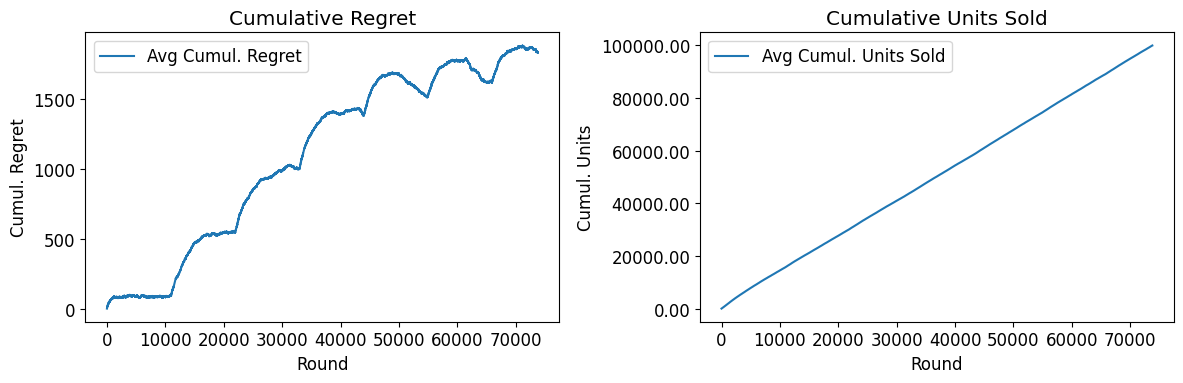

Final avg units sold: 100000.00
Final avg regret per round: 0.0249


In [ ]:
N_products = 3
base_prices = np.linspace(0, 1, 15)
dummy_price = 1.001
price_grid = [
     np.concatenate([base_prices, [dummy_price]])
    for _ in range(N_products)
]

T = 100_000
B = 100_000
seed = 18
num_windows = 4
window_size = int(2*1 * np.sqrt(T * np.log(T)/num_windows)) # Adjusted window size for exploration
    
window_size = int(np.sqrt(T))
    
window_size = int((T * np.log(T)) ** (2/3))
    
    

# Generate valuation data for computing the clairvoyant expected reward.
rng_val = np.random.default_rng(seed)
# Use num_windows=5 for the valuation generation (can be adjusted as needed).
expected_means, V = generate_smooth_valuation_data(T, num_windows, N_products,max_jump=0.02, transition_frac=0.0, concentration=10, rng=rng_val)
expected_means, V = generate_one_sided_valuation_data(
    T, segments=num_windows, products=N_products,
    max_jump=0.02, transition_frac=0.2, concentration=10, rng=rng_val
)
full_prices = price_grid[0]   
clair_reward, simplex, expected_cost = compute_extended_clairvoyant(V,full_prices , B)
print(f"Clairvoyant expected reward per round: {clair_reward:.4f} and simplex: {simplex}")

n_trials = 1

all_regrets, all_units = [], []

for trial in range(n_trials):
    print(f"Trial {trial+1}/{n_trials}...")
    rng = np.random.default_rng(seed + trial)
    env = SmoothMultiProductPricingEnvironment(price_grid, T, valuations=V, rng=rng)
    agent = SlidingConstrainedCombinatorialUCBAgent(price_grid, B, T ,window_size= window_size, rng=rng)

    cum_regret, cum_units = 0.0, 0
    regrets, units = [], []

    for t in range(T):
        choice = agent.pull_arm()
        if choice is None:
            print(f"Trial {trial+1}: Ran out of budget or time at round {t}.")
            break
        rewards, costs , _ = env.round(choice) #valuations are returned but not used here
        # Synchronize agent time with environment's time
        agent.t = env.t
        agent.update(rewards, costs)
            

        actual_rew = rewards.sum()
        actual_units = costs.sum()
        cum_regret += (clair_reward - actual_rew)
        cum_units += actual_units
        regrets.append(cum_regret)
        units.append(cum_units)

    all_regrets.append(regrets)
    all_units.append(units)

# Aggregate and plot
min_len = min(len(r) for r in all_regrets)
avg_regret = np.mean([r[:min_len] for r in all_regrets], axis=0)
sd_regret  = np.std([r[:min_len] for r in all_regrets], axis=0)
avg_units  = np.mean([u[:min_len] for u in all_units], axis=0)
sd_units   = np.std([u[:min_len] for u in all_units], axis=0)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(avg_regret, label="Avg Cumul. Regret")
plt.fill_between(np.arange(min_len),
                    avg_regret - sd_regret/np.sqrt(n_trials),
                    avg_regret + sd_regret/np.sqrt(n_trials), alpha=0.3)
plt.xlabel("Round"); plt.ylabel("Cumul. Regret")
plt.title("Cumulative Regret")
plt.legend()

plt.subplot(1, 2, 2)
import matplotlib.ticker as ticker
ax = plt.gca()
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))
plt.plot(avg_units, label="Avg Cumul. Units Sold")
plt.fill_between(np.arange(min_len),
                    avg_units - sd_units/np.sqrt(n_trials),
                    avg_units + sd_units/np.sqrt(n_trials), alpha=0.3)
plt.xlabel("Round"); plt.ylabel("Cumul. Units")
plt.title("Cumulative Units Sold")
plt.legend()

plt.tight_layout()
plt.show()

print(f"Final avg units sold: {avg_units[-1]:.2f}")
print(f"Final avg regret per round: {avg_regret[-1]/min_len:.4f}")







Clairvoyant expected reward per round: 0.5987 and simplex: [[ 0.          0.          0.          0.          0.          0.
   0.         -0.          1.          0.          0.          0.
   0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          1.          0.          0.
   0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.74267155  0.25732845  0.          0.          0.
   0.          0.          0.          0.        ]]
Trial 1/1...


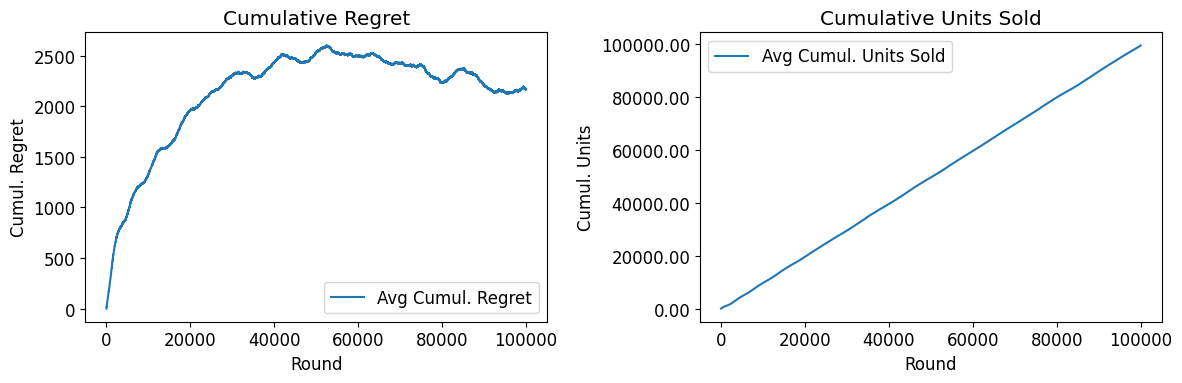

Final avg units sold: 99570.00
Final avg regret per round: 0.0217


In [20]:
N_products = 3
base_prices = np.linspace(0, 1, 15)
dummy_price = 1.001
price_grid = [
     np.concatenate([base_prices, [dummy_price]])
    for _ in range(N_products)
]

T = 100_000
B = 100_000
seed = 18
num_windows = 4
window_size = int(2*1 * np.sqrt(T * np.log(T)/num_windows)) # Adjusted window size for exploration
    
window_size = int(np.sqrt(T))
    
window_size = int((T * np.log(T)) ** (2/3))
    
    

# Generate valuation data for computing the clairvoyant expected reward.
rng_val = np.random.default_rng(seed)
# Use num_windows=5 for the valuation generation (can be adjusted as needed).
expected_means, V = generate_smooth_valuation_data(T, num_windows, N_products,max_jump=0.02, transition_frac=0.0, concentration=10, rng=rng_val)
'''
expected_means, V = generate_one_sided_valuation_data(
    T, segments=num_windows, products=N_products,
    max_jump=0.02, transition_frac=0.2, concentration=10, rng=rng_val
)
'''
full_prices = price_grid[0]   
clair_reward, simplex, expected_cost = compute_extended_clairvoyant(V,full_prices , B)
print(f"Clairvoyant expected reward per round: {clair_reward:.4f} and simplex: {simplex}")

n_trials = 1

all_regrets, all_units = [], []

for trial in range(n_trials):
    print(f"Trial {trial+1}/{n_trials}...")
    rng = np.random.default_rng(seed + trial)
    env = SmoothMultiProductPricingEnvironment(price_grid, T, valuations=V, rng=rng)
    eta = 1 / np.sqrt(T)
    agent = MultiProductFFPrimalDualPricingAgent(price_grid[0], T, B, N_products, rng, eta)
    cum_regret, cum_units = 0.0, 0
    regrets, units = [], []

    for t in range(T):
        choice = agent.pull_arm()
        if choice is None:
            print(f"Trial {trial+1}: Ran out of budget or time at round {t}.")
            break
        rewards, costs , valuations = env.round(choice)
        # Synchronize agent time with environment's time
        agent.t = env.t
        agent.update(valuations)
            

        actual_rew = rewards.sum()
        actual_units = costs.sum()
        cum_regret += (clair_reward - actual_rew)
        cum_units += actual_units
        regrets.append(cum_regret)
        units.append(cum_units)

    all_regrets.append(regrets)
    all_units.append(units)

# Aggregate and plot
min_len = min(len(r) for r in all_regrets)
avg_regret = np.mean([r[:min_len] for r in all_regrets], axis=0)
sd_regret  = np.std([r[:min_len] for r in all_regrets], axis=0)
avg_units  = np.mean([u[:min_len] for u in all_units], axis=0)
sd_units   = np.std([u[:min_len] for u in all_units], axis=0)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(avg_regret, label="Avg Cumul. Regret")
plt.fill_between(np.arange(min_len),
                    avg_regret - sd_regret/np.sqrt(n_trials),
                    avg_regret + sd_regret/np.sqrt(n_trials), alpha=0.3)
plt.xlabel("Round"); plt.ylabel("Cumul. Regret")
plt.title("Cumulative Regret")
plt.legend()

plt.subplot(1, 2, 2)
import matplotlib.ticker as ticker
ax = plt.gca()
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))
plt.plot(avg_units, label="Avg Cumul. Units Sold")
plt.fill_between(np.arange(min_len),
                    avg_units - sd_units/np.sqrt(n_trials),
                    avg_units + sd_units/np.sqrt(n_trials), alpha=0.3)
plt.xlabel("Round"); plt.ylabel("Cumul. Units")
plt.title("Cumulative Units Sold")
plt.legend()

plt.tight_layout()
plt.show()

print(f"Final avg units sold: {avg_units[-1]:.2f}")
print(f"Final avg regret per round: {avg_regret[-1]/min_len:.4f}")





